<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/NeuralWardrobe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">NeuralWardrobe v.1.1</font></b>

![visitors](https://visitor-badge.glitch.me/badge?page_id=mlart.NeuralWardrobe&left_color=black&right_color=orange)

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [ru-dalle](https://github.com/sberbank-ai/ru-dalle)

Creator: **[sberbank-ai](https://github.com/sberbank-ai), [Eyal Gruss](https://eyalgruss.com)**

Colab based on eyaler's [notebook](https://colab.research.google.com/gist/eyaler/0cee9a71f5dd3fdfa9c0c03656ebdd4c/rudalle-outpainting.ipynb).

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@MLArt](https://t.me/MLArt),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---

- **upd 1.1** - The algorithm now generates images 10 times faster.

---

```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, поочередно нажимайте на кнопки (куда указывают красные стрелки), дожидаясь завершения выполнения каждого блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries (~3 min.)</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые библиотеки (~3 мин.)</font></b>

!pip install rudalle==0.4.0 > /dev/null
!pip install translators==4.11.0 > /dev/null
!pip install face-alignment

from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_clip
from rudalle.image_prompts import ImagePrompts
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan, get_ruclip
from rudalle.utils import seed_everything
from PIL import Image, ImageOps
import torch
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
from google.colab import files, _message
import numpy as np
import translators
import requests
import os
import cv2
import json
import sys
from tqdm import tqdm
import scipy.ndimage
import face_alignment

landmarks_detector = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, flip_input=False)

dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device='cuda')
realesrgan = {x: get_realesrgan('x%d'%x, device='cuda') for x in [2,4,8]} 
tokenizer = get_tokenizer()
vae = get_vae().to('cuda')
dwt_vae = get_vae(dwt=True).to('cuda')
ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')
ruclip = ruclip.to('cuda')

clear_output()
print('Done!')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить изображение</font></b>

image_url = "" #@param {type:"string"}
orig_images = []

if image_url == '':
  uploaded = list(files.upload().keys())
  if len(uploaded) > 1: raise ValueError('Upload only one image!')
  name = uploaded[0]
else:
  try:
    !wget $image_url
    name = image_url.split('/')[-1]
  except BaseException:
    print("Error. Upload image from your local machine")

filenames = [name]
orig_images = [ImageOps.exif_transpose(Image.open(name)).convert('RGB')]
width, height = orig_images[0].size
try:
  face_landmarks = landmarks_detector.get_landmarks(name)
except:
  face_landmarks = 0

if len(orig_images) == 1 and face_landmarks != 0:
  clear_output()
  print('Done!')

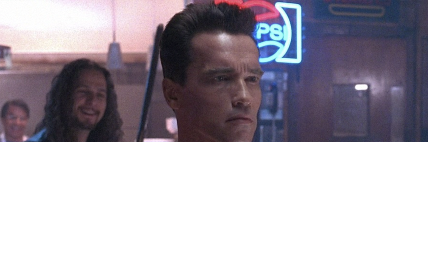

In [12]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Remove part of the image with old clothes</font></b> {run: "auto"}
#@markdown <b><font color="black" size="+1"> (RUS) Удаляем часть изображения со старой одеждой</font></b>

top_frac = 0.55 #@param {type:'slider', max:1, step:0.01}
top = int(height * top_frac)
auto_remove = False #@param {type:'boolean'}
if auto_remove:
  try: 
    top = int(face_landmarks[0][48:60, 1].max())
    top_frac = round((top/height)+0.005,2)
  except: 
    print('Face not found')
    top = int(height * top_frac)

img = cv2.imread(name)
img[top:] = (img[top:]*0)+255

scale = round(256/min(width, height),2)
resized_image = cv2.resize(img, (0,0), fx=scale, fy=scale)
cv2_imshow(resized_image)

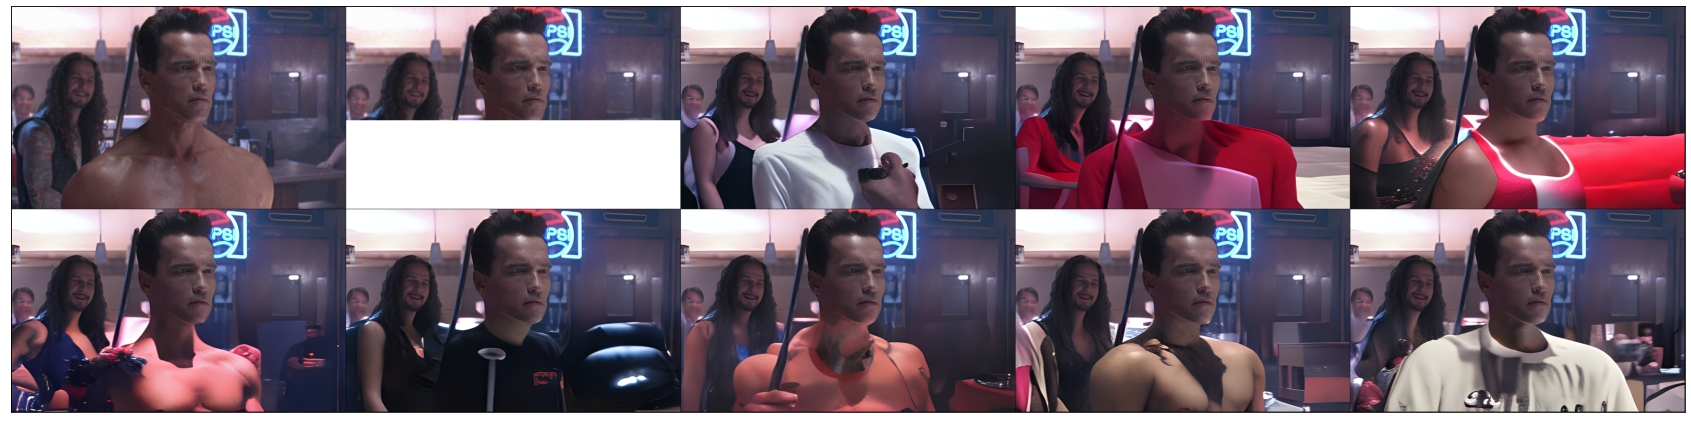

files saved to output folders:
/content/output/0001


In [13]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Run</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Запуск</font></b>

!rm -rf /content/output/*

#@markdown Optional text prompt (can leave empty):
text = '' #@param {type:'string'}
crop_order = 'after_encoding'
#@markdown Increase for more diverse results, decrease for less:
temperature = 1 #@param {type:'number'}
#@markdown Increase these for more and better results, but will take longer:
display_grid = '3x1' #@param ['3x1', '3x2', '3x3', '4x1', '4x2', '4x3', '4x4']
num_levels = int(display_grid.split('x')[1])
retries_per_level = int(display_grid.split('x')[0])-2
#@markdown Upscale result:
fix_aspect_ratio = 'before_clip'
paste_original_part_over_generated = 'between_clip_and_super_resolution'
blend_frac = 0.1
dwt_decoder_upscale = False
super_resolution_factor = 4 #@param [1, 2, 4, 8] {type:'raw'}
#@markdown Set to a positive number for reproducing results (different results for different numbers):
random_seed =  -1 #@param {type:'integer'}
if random_seed < 1:
    random_seed = None
if random_seed:
    seed_everything(random_seed)
max_display_results = num_levels * retries_per_level
nrow = int(np.ceil((max_display_results+2)/np.ceil((max_display_results+2)/6)))
show_size = 30  
crop_orders = [0,1]
if crop_order == 'after_encoding':
    crop_orders = [0]
elif crop_order == 'before_encoding':
    crop_orders = [1]

enc_size = 32

def crop(im, borders, mask=None):
    im = np.array(im)
    if mask is not None:
        mask = np.array(mask)
        assert im.shape == mask.shape, (im.shape, mask.shape)    
    if borders['up']:
        i = int(round(im.shape[0]*borders['up']/enc_size))
        z = max(i-int(round(blend_frac*im.shape[0])), 0)
        if mask is None:
            im[i:] = 255
        else:
            im[:z] = mask[:z]
            for j in range(z, i):
                alpha = (j-z+1)/(i-z+1)
                im[j] = im[j]*alpha+mask[j]*(1-alpha)
    elif borders['down']:
        i = int(round(im.shape[0]*borders['down']/enc_size))
        z = min(i+int(round(blend_frac*im.shape[0])), im.shape[0])
        if mask is None:
            im[:i] = 255
        else:
            im[z:] = mask[z:]
            for j in range(i, z):
                alpha = (j-i+1)/(z-i+1)
                im[j] = im[j]*(1-alpha)+mask[i:z]*alpha
    elif borders['left']:
        i = int(round(im.shape[1]*borders['left']/enc_size))
        z = max(i-int(round(blend_frac*im.shape[1])), 0)
        if mask is None:
            im[:,i:] = 255
        else:
            im[:,:z] = mask[:,:z]
            for j in range(z, i):
                alpha = (j-z+1)/(i-z+1)
                im[:,j] = im[:,j]*alpha+mask[:,j]*(1-alpha)
    elif borders['right']:
        i = int(round(im.shape[1]*borders['right']/enc_size))
        z = min(i+int(round(blend_frac*im.shape[1])), im.shape[1])
        if mask is None:
            im[:,:i] = 255
        else:
            im[:,z:] = mask[:,z:]
            for j in range(i, z):
                alpha = (j-i+1)/(z-i+1)
                im[:,j] = im[:,j]*(1-alpha)+mask[:,j]*alpha
    im = Image.fromarray(im)
    return im

images = [im.resize((256,256)) for im in orig_images]
borders_flips = []
borders_flips.append(({'up': int(round(enc_size*top_frac)), 'left': 0, 'right': 0, 'down': 0}, False))

def simple_detect_lang(text):
    if len(set('абвгдежзийклмнопрстуфхцчшщъыьэюяё').intersection(text.lower())):
        return 'ru'
    if len(set('אבגדהוזחטיכךלמםנןסעפצץקרשת').intersection(text)):
        return 'iw'
    if len(set('abcdefghijklmnopqrstuvwxyz').intersection(text.lower())):
        return 'en'
    return 'auto'

if text:
  orig_text = text
  lang = simple_detect_lang(text)
  if lang != 'ru':
      text = translators.google(text, from_language=lang, to_language='ru')
  back_text = translators.google(text, from_language='ru', to_language=lang if lang not in ['auto','ru'] else 'en')
  print('original text:', orig_text)
  print('language detected:', lang)
  print('prompt in russian:', text)
  print('back translation:' if lang not in ['auto','ru'] else 'english translation', back_text)
texts = [text]

levels = [
            (2048, 0.995),
            (1024, 0.98),
            (1536, 0.99),
            (1024, 0.99),
            (512, 0.97),
            (384, 0.96),
            (256, 0.95),
            (128, 0.95),
            (64, 0.92),
        ]
level_indices = list(range(len(levels)))

save_dir = None
save_dirs = []
os.makedirs('/content/output', exist_ok=True)
notebook = _message.blocking_request('get_ipynb', timeout_sec=60)
all_hires = []
for j, (image, orig, filename) in enumerate(zip(images, orig_images, filenames), start=1):
    print('%d/%d: %s'%(j,len(filenames),filename))
    for borders, flip in borders_flips:
        if flip:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            orig = orig.transpose(Image.FLIP_TOP_BOTTOM)
        for text_to_use in texts:
            for crop_first in crop_orders:
                out_images = []
                scores = []
                image_prompt = ImagePrompts(image, borders, dwt_vae if dwt_decoder_upscale else vae, torch.device('cuda'), crop_first=crop_first)
                for i in level_indices[:num_levels]:
                    top_k, top_p = levels[i]
                    _pil_images, _scores = generate_images(
                        text_to_use,
                        tokenizer,
                        dalle,
                        dwt_vae if dwt_decoder_upscale else vae,
                        top_k=top_k,
                        top_p=top_p,
                        images_num=retries_per_level,
                        image_prompts=image_prompt,
                        temperature=temperature,
                        seed=random_seed,
                        use_cache=False
                    )
                    out_images += _pil_images
                    scores += _scores
                aspect = (1, orig.size[1]/orig.size[0]) if orig.size[1]>orig.size[0] else (orig.size[0]/orig.size[1], 1) if orig.size[0]>orig.size[1] else (1,1)
                if fix_aspect_ratio == 'before_clip' and (aspect[0]!=1 or aspect[1]!=1):
                    out_images = [im.resize((int(aspect[0]*im.size[0]), int(aspect[1]*im.size[0]))) for im in out_images]
                rescaled_orig = None
                if paste_original_part_over_generated.startswith('before_clip'):
                    if image.size == out_images[0].size: 
                        rescaled_orig = image
                    elif orig.size == out_images[0].size:
                        rescaled_orig = orig
                    else:
                        rescaled_orig = orig.resize(out_images[0].size)
                    out_images = [crop(im, borders, mask=rescaled_orig) for im in out_images]
                if text_to_use:
                    if flip and flip_result_back == 'before_clip':
                        out_images = [im.transpose(Image.FLIP_TOP_BOTTOM) for im in out_images]
                    out_images, _ = cherry_pick_by_clip(out_images, text_to_use, ruclip, ruclip_processor, device='cuda', count=None)
                    if flip and flip_result_back == 'before_clip':
                        out_images = [im.transpose(Image.FLIP_TOP_BOTTOM) for im in out_images]
                else:
                    out_images, _ = zip(*sorted(zip(out_images, scores), key=lambda x: -x[1]))
                out_images = list(out_images[:max_display_results])
                if fix_aspect_ratio == 'after_clip' and (aspect[0]!=1 or aspect[1]!=1):
                    out_images = [im.resize((int(aspect[0]*im.size[0]), int(aspect[1]*im.size[0]))) for im in out_images]
                if paste_original_part_over_generated == 'between_clip_and_super_resolution':
                    if rescaled_orig is None or rescaled_orig.size != out_images[0].size: 
                        if image.size == out_images[0].size: 
                            rescaled_orig = image
                        elif orig.size == out_images[0].size:
                            rescaled_orig = orig
                        else:
                            rescaled_orig = orig.resize(out_images[0].size)  
                    out_images = [crop(im, borders, mask=rescaled_orig) for im in out_images]
                if super_resolution_factor > 1:
                    out_images = super_resolution(out_images, realesrgan[super_resolution_factor])
                if rescaled_orig is None or rescaled_orig.size != out_images[0].size: 
                    if image.size == out_images[0].size: 
                        rescaled_orig = image
                    elif orig.size == out_images[0].size:
                        rescaled_orig = orig
                    else:
                        rescaled_orig = orig.resize(out_images[0].size)
                if paste_original_part_over_generated.endswith('after_super_resolution'):
                    out_images = [crop(im, borders, mask=rescaled_orig) for im in out_images]  
                out_images = [rescaled_orig, crop(rescaled_orig, borders)] + out_images
                if flip and flip_result_back != 'no':
                    out_images = [im.transpose(Image.FLIP_TOP_BOTTOM) for im in out_images]                    
                all_hires.append(out_images)
                folders = [int(folder) for folder in os.listdir('/content/output') if os.path.isdir(os.path.join('/content/output', folder)) and folder.isnumeric()]
                save_dir = os.path.join('/content/output', '%04d'%(max(folders, default=0)+1)) 
                save_dirs.append(save_dir)
                clear_output()
                show(out_images, nrow, save_dir=save_dir, size=show_size)

if save_dirs:
    print('files saved to output folders:')
    for save_dir in save_dirs:
        print(save_dir)

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download high-resolution images</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Скачать изображения в высоком разрешении</font></b>

if save_dirs:
  save_file = os.path.join('/content', save_dirs[-1].rsplit('/',1)[-1] + '.zip')  
  if len(save_dirs)==1:
      save_dirs_str = save_dirs[-1]
      !zip -rjqFS $save_file $save_dirs_str
  else:
      save_dirs_str = ' '.join(save_dir.rsplit('/',1)[-1] for save_dir in save_dirs)
      %pushd /content/output
      !zip -rqFS $save_file $save_dirs_str
      %popd
  files.download(save_file)